<a href="https://colab.research.google.com/github/tcharos/AIDL_B02-Advanced-Topics-in-Deep-Learning/blob/main/agent_based_dqn_space_invaders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Agent-Based DQN for Space Invaders

Implementation of DQN variants using Agent class with hard target updates:
- Standard DQN
- Double DQN
- Duelling DQN
- Prioritized Experience Replay (PER)
- Learning Rate Scheduling
- Graceful Interruption (Ctrl+C)

## Install Dependencies

In [48]:
!pip install gymnasium[atari,accept-rom-license]
!pip install ale-py
!pip install torch scipy numpy psutil
!pip install opencv-python matplotlib
!pip install "imageio[ffmpeg]"

zsh:1: no matches found: gymnasium[atari,accept-rom-license]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 7.2 MB/s  0:00:02m0:00:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [imageio]m1/2 [imageio]


In [49]:
# Import and verify ALE is available
import ale_py
import gymnasium as gym
gym.register_envs(ale_py)

## Import Libraries

In [50]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from collections import deque
import random
import cv2
import matplotlib.pyplot as plt
import psutil
import os
from datetime import datetime
import imageio

## Device Configuration

In [ ]:
# Set device (MPS for Mac, CUDA for GPU, CPU otherwise)
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Apple Silicon)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA")
else:
    device = torch.device("cpu")
    print("Using CPU")

print(f"Device: {device}")

## Google Drive Setup

In [55]:
USE_GDRIVE = False  # Set to True to enable Google Drive integration

if USE_GDRIVE:
    from google.colab import drive
    drive.mount('/content/drive')
    CHECKPOINT_DIR = '/content/drive/MyDrive/DQN_SpaceInvaders_Checkpoints'
    BEST_MODELS = '/content/drive/MyDrive/DQN_SpaceInvaders_BestModels'
    os.makedirs(CHECKPOINT_DIR, exist_ok=True)
    os.makedirs(BEST_MODELS, exist_ok=True)
    print(f"Checkpoints will be saved to: {CHECKPOINT_DIR}")
    print(f"Best models will be saved to: {BEST_MODELS}")
else:
    CHECKPOINT_DIR = './checkpoints'
    BEST_MODELS = './best_models'
    DELIVERABLES_MODELS = './deliverables'
    os.makedirs(CHECKPOINT_DIR, exist_ok=True)
    os.makedirs(BEST_MODELS, exist_ok=True)
    os.makedirs(DELIVERABLES_MODELS, exist_ok=True)
    print(f"Checkpoints will be saved locally to: {CHECKPOINT_DIR}")
    print(f"Best models will be saved locally to: {BEST_MODELS}")

Checkpoints will be saved locally to: ./checkpoints
Best models will be saved locally to: ./best_models


## Helper Functions

In [57]:
def save_checkpoint(config, policy_net, target_net, optimizer, episode, avg_score, 
                   episode_rewards, is_best=False):
    """Save model checkpoint"""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    dqn_type = config['DQN_TYPE']
    per_suffix = "_PER" if config['USE_PER'] else ""
    
    if is_best:
        filename = f"{dqn_type}{per_suffix}_best.pth"
        filepath = os.path.join(config['BEST_MODELS_DIR'], filename)
        print(f'\t\tNew best avg: {avg_score:.2f} - saved to {filename}')
    else:
        filename = f"{dqn_type}{per_suffix}_ep{episode}.pth"
        filepath = os.path.join(config['CHECKPOINT_DIR'], filename)
        print(f'\t\tCheckpoint saved: {filename}')

    torch.save({
        'episode': episode,
        'config': config,
        'policy_net_state_dict': policy_net.state_dict(),
        'target_net_state_dict': target_net.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'episode_rewards': episode_rewards,
        'avg_score': avg_score,
        'timestamp': timestamp
    }, filepath)
    
    return filepath


def print_config(config):
    """Print configuration in a formatted way"""
    print("\n" + "="*70)
    print(f"  DQN TYPE: {config['DQN_TYPE']}")
    if config['USE_PER']:
        print(f"  Using Prioritized Experience Replay (PER)")
    print("="*70)
    print("\nConfiguration:")
    print("-"*70)
    for key, value in config.items():
        if key not in ['CHECKPOINT_DIR']:  # Skip long paths
            print(f"  {key:20s}: {value}")
    print("="*70 + "\n")


def plot_multiple_models(checkpoint_paths, labels=None, window_size=100):
    """
    Plots the moving average training rewards for multiple models on one chart.
    
    Args:
        checkpoint_paths (list): List of strings (paths to .pth files).
        labels (list): Optional list of custom names for the legend. 
                       If None, it tries to infer from config.
        window_size (int): Smoothing window.
    """
    plt.figure(figsize=(12, 6))
    
    # Standard distinct colors for plotting
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    
    print(f"{'Model Name':<30} | {'Max Score':<10} | {'Ep @ Max':<10} | {'Final Avg':<10}")
    print("-" * 75)

    for idx, path in enumerate(checkpoint_paths):
        if not os.path.exists(path):
            print(f"⚠️ File not found: {path}")
            continue
            
        try:
            checkpoint = torch.load(path, map_location=torch.device('cpu'), weights_only=False)
            rewards = checkpoint.get('episode_rewards', [])
            
            if not rewards:
                continue

            # Determine Label
            if labels and idx < len(labels):
                model_label = labels[idx]
            else:
                # Auto-generate label from config
                config = checkpoint.get('config', {})
                dqn_type = config.get('DQN_TYPE', 'DQN')
                use_per = config.get('USE_PER', False)
                model_label = f"{dqn_type}{' + PER' if use_per else ''}"

            # Calculate Moving Average
            moving_avg = []
            for i in range(len(rewards)):
                start = max(0, i - window_size + 1)
                window = rewards[start : i + 1]
                moving_avg.append(np.mean(window))
            
            # Plot Curve
            episodes = range(1, len(rewards) + 1)
            color = colors[idx % len(colors)]
            plt.plot(episodes, moving_avg, linewidth=2, color=color, label=model_label)
            
            # Calculate Stats for Table
            max_score = np.max(rewards)
            max_ep = np.argmax(rewards) + 1
            final_avg = moving_avg[-1]
            
            print(f"{model_label:<30} | {max_score:<10.0f} | {max_ep:<10d} | {final_avg:<10.2f}")

        except Exception as e:
            print(f"❌ Error loading {path}: {e}")

    # Chart Formatting
    plt.title("Comparison of Agents", fontsize=14)
    plt.xlabel("Episode", fontsize=12)
    plt.ylabel(f"Average Score (Last {window_size})", fontsize=12)
    
    # Goal Lines
    plt.axhline(y=400, color='gray', linestyle=':', label='Goal (400)')
    plt.axhline(y=500, color='black', linestyle='--', alpha=0.5, label='Goal (500)')
    
    plt.legend(loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def record_agent_gameplay(checkpoint_path, output_prefix='agent_gameplay', num_episodes=1, max_steps=10000):
    """
    Loads a trained model and records videos of it playing.
    """
    # 1. Load Checkpoint
    if not os.path.exists(checkpoint_path):
        print(f"❌ Error: Checkpoint not found at {checkpoint_path}")
        return

    print(f"qc Loading checkpoint: {checkpoint_path}...")
    # weights_only=False fixes the numpy error you saw earlier
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'), weights_only=False)
    
    # 2. Extract Configuration
    config = checkpoint.get('config', {})
    
    # OPTIMIZATION: Set buffer size to 1 to save RAM (we don't need replay memory for recording)
    recording_config = config.copy()
    recording_config['BUFFER_SIZE'] = 1 
    
    # 3. Setup Environment
    env = gym.make(config.get('ENV_ID', 'ALE/SpaceInvaders-v5'), render_mode='rgb_array')
    
    # Ensure N_ACTIONS exists in config (in case it wasn't saved)
    if 'N_ACTIONS' not in recording_config:
        recording_config['N_ACTIONS'] = env.action_space.n

    # 4. Initialize Agent CORRECTLY
    # Passing the config dict instead of separate arguments
    agent = DQNAgent(
        config=recording_config,
        device='cpu'
    )
    
    # 5. Load the trained weights
    agent.policy_net.load_state_dict(checkpoint['policy_net_state_dict'])
    agent.policy_net.eval() # Switch to evaluation mode

    # 6. Gameplay Loop
    total_score = 0
    
    for i in range(1, num_episodes + 1):
        frames = []
        episode_reward = 0
        
        # Varied seed for different gameplay
        seed = config.get('SEED', 42) + (i * 100)
        raw_state, _ = env.reset(seed=seed)
        
        # Initialize Frame Stacking
        processed_state = preprocess_frame(raw_state)
        state_stack = deque([processed_state] * config['N_FRAMES'], maxlen=config['N_FRAMES'])
        
        print(f"🎥 Recording Episode {i}/{num_episodes}...")
        
        for step in range(max_steps):
            frame = env.render()
            frames.append(frame)
            
            # Select Action (Greedy / Low Epsilon)
            state_array = np.array(state_stack)
            action = agent.act(state_array, epsilon=0.01) 
            
            # Step
            next_raw_state, reward, terminated, truncated, _ = env.step(action)
            episode_reward += reward
            
            # Update State
            processed_next = preprocess_frame(next_raw_state)
            state_stack.append(processed_next)
            
            if terminated or truncated:
                break
        
        total_score += episode_reward
        
        # Save Video
        filename = f"{output_prefix}_ep{i}_score_{int(episode_reward)}.mp4"
        filepath = os.path.join(DELIVERABLES_MODELS, filename)
        try:
            imageio.mimsave(filepath, frames, fps=30)
            print(f"   ✅ Saved {filename} (Score: {episode_reward})")
        except Exception as e:
            print(f"   ❌ Error saving video: {e}")

    env.close()
    return total_score

## Neural Network Architectures

In [ ]:
class DQN(nn.Module):
    """Standard DQN network."""
    
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        conv_out_size = self._get_conv_out(input_shape)
        
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )
    
    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))
    
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


class DuellingDQN(nn.Module):
    """Duelling DQN network - separates value and advantage streams."""
    
    def __init__(self, input_shape, n_actions):
        super(DuellingDQN, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        conv_out_size = self._get_conv_out(input_shape)
        
        # Value stream
        self.value_stream = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )
        
        # Advantage stream
        self.advantage_stream = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )
    
    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))
    
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        
        value = self.value_stream(x)
        advantage = self.advantage_stream(x)
        
        # Combine value and advantage: Q(s,a) = V(s) + (A(s,a) - mean(A))
        q_values = value + (advantage - advantage.mean(dim=1, keepdim=True))
        return q_values

## Replay Buffers

In [ ]:
class ReplayBuffer:
    """Standard uniform replay buffer."""
    
    def __init__(self, buffer_size):
        self.buffer = deque(maxlen=buffer_size)
    
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            np.array(states),
            np.array(actions),
            np.array(rewards, dtype=np.float32),
            np.array(next_states),
            np.array(dones, dtype=np.float32)
        )
    
    def __len__(self):
        return len(self.buffer)


class PrioritizedReplayBuffer:
    """Prioritized Experience Replay buffer."""
    
    def __init__(self, buffer_size, alpha=0.6, beta_start=0.4, beta_frames=100000, epsilon=1e-6):
        self.buffer = deque(maxlen=buffer_size)
        self.priorities = deque(maxlen=buffer_size)
        self.alpha = alpha
        self.beta_start = beta_start
        self.beta_frames = beta_frames
        self.epsilon = epsilon
        self.frame = 0
        self.max_priority = 1.0
    
    def beta_schedule(self):
        """Linearly increase beta from beta_start to 1.0."""
        return min(1.0, self.beta_start + self.frame * (1.0 - self.beta_start) / self.beta_frames)
    
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
        self.priorities.append(float(self.max_priority))
    
    def sample(self, batch_size):
        self.frame += 1
        beta = self.beta_schedule()
        
        priorities = np.array(self.priorities)
        probs = priorities ** self.alpha
        probs /= probs.sum()
        
        indices = np.random.choice(len(self.buffer), batch_size, p=probs, replace=False)
        
        # Importance sampling weights
        weights = (len(self.buffer) * probs[indices]) ** (-beta)
        weights /= weights.max()
        
        batch = [self.buffer[idx] for idx in indices]
        states, actions, rewards, next_states, dones = zip(*batch)
        
        return (
            np.array(states),
            np.array(actions),
            np.array(rewards, dtype=np.float32),
            np.array(next_states),
            np.array(dones, dtype=np.float32),
            indices,
            weights.astype(np.float32)
        )
    
    def update_priorities(self, indices, td_errors):
        """Update priorities based on TD errors."""
        td_errors = td_errors.flatten()
        for idx, error in zip(indices, td_errors):
            priority = (abs(error) + self.epsilon) ** self.alpha
            self.priorities[idx] = float(priority) 
            self.max_priority = max(self.max_priority, float(priority))
    
    def __len__(self):
        return len(self.buffer)

## Preprocessing

In [ ]:
def preprocess_frame(frame):
    """Preprocess Space Invaders frame: grayscale + resize to 84x84."""
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    resized = cv2.resize(gray, (84, 84), interpolation=cv2.INTER_AREA)
    normalized = resized / 255.0
    return normalized.astype(np.float32)

## Agent Class with Hard Target Updates

In [ ]:
class DQNAgent:
    """DQN Agent with hard target network updates."""
    
    def __init__(self, config, device='cpu'):
        """
        Initialize DQN Agent.
        
        Args:
            config (dict): Configuration dictionary
            device (str): Device to use ('cpu', 'cuda', 'mps')
        """
        self.config = config
        self.device = device
        self.n_actions = config['N_ACTIONS']
        
        # Create networks
        input_shape = (config['N_FRAMES'], 84, 84)
        if config['DQN_TYPE'] == 'DuellingDQN':
            self.policy_net = DuellingDQN(input_shape, self.n_actions).to(device)
            self.target_net = DuellingDQN(input_shape, self.n_actions).to(device)
        else:
            self.policy_net = DQN(input_shape, self.n_actions).to(device)
            self.target_net = DQN(input_shape, self.n_actions).to(device)
        
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        
        # Optimizer
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=config['LEARNING_RATE'])
        
        # LR Scheduler (optional)
        self.scheduler = None
        if config.get('LR_SCHEDULER', False):
            self.scheduler = ExponentialLR(self.optimizer, gamma=config.get('LR_GAMMA', 0.9995))
        
        # Replay buffer
        if config.get('USE_PER', False):
            self.memory = PrioritizedReplayBuffer(
                config['BUFFER_SIZE'],
                alpha=config.get('PER_ALPHA', 0.6),
                beta_start=config.get('PER_BETA_START', 0.4),
                beta_frames=config.get('PER_BETA_FRAMES', 100000),
                epsilon=config.get('PER_EPSILON', 1e-6)
            )
        else:
            self.memory = ReplayBuffer(config['BUFFER_SIZE'])
        
        self.steps = 0
    
    def act(self, state, epsilon):
        """Select action using epsilon-greedy policy."""
        if random.random() < epsilon:
            return random.randrange(self.n_actions)
        else:
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            with torch.no_grad():
                q_values = self.policy_net(state_tensor)
            return q_values.argmax().item()
    
    def step(self, state, action, reward, next_state, done):
        """Store experience and learn."""
        # Store experience
        self.memory.push(state, action, reward, next_state, done)
        self.steps += 1
        
        # Learn from experience
        if len(self.memory) >= self.config['BATCH_SIZE']:
            self.learn()
        
        # Hard update target network
        if self.steps % self.config['TARGET_UPDATE'] == 0:
            self.update_target_network()
    
    def learn(self):
        """Update policy network using batch of experiences."""
        # Sample from memory
        use_per = self.config.get('USE_PER', False)
        
        if use_per:
            states, actions, rewards, next_states, dones, indices, weights = self.memory.sample(self.config['BATCH_SIZE'])
        else:
            states, actions, rewards, next_states, dones = self.memory.sample(self.config['BATCH_SIZE'])
            weights = np.ones(self.config['BATCH_SIZE'])
            indices = None
        
        # Convert to tensors
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(self.device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(self.device)
        weights = torch.FloatTensor(weights).unsqueeze(1).to(self.device)
        
        # Get current Q values
        current_q_values = self.policy_net(states).gather(1, actions)
        
        # Compute target Q values
        with torch.no_grad():
            if self.config['DQN_TYPE'] == 'DoubleDQN':
                # Double DQN: use policy net to select actions, target net to evaluate
                next_actions = self.policy_net(next_states).argmax(1, keepdim=True)
                next_q_values = self.target_net(next_states).gather(1, next_actions)
            else:
                # Standard DQN (or Duelling DQN)
                next_q_values = self.target_net(next_states).max(1, keepdim=True)[0]
            
            target_q_values = rewards + (1 - dones) * self.config['GAMMA'] * next_q_values
        
        # Compute loss
        td_errors = target_q_values - current_q_values
        loss = (td_errors.pow(2) * weights).mean()
        
        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), max_norm=10.0)
        self.optimizer.step()
        
        # Update priorities if using PER
        if use_per and indices is not None:
            self.memory.update_priorities(indices, td_errors.detach().cpu().numpy())
        
        return loss.item()
    
    def update_target_network(self):
        """Hard update: copy policy network weights to target network."""
        self.target_net.load_state_dict(self.policy_net.state_dict())
    
    def get_epsilon(self, episode_steps):
        """Calculate current epsilon based on decay schedule."""
        epsilon = self.config['EPSILON_END'] + (self.config['EPSILON_START'] - self.config['EPSILON_END']) * \
                  np.exp(-1. * episode_steps / self.config['EPSILON_DECAY'])
        return epsilon

## Training Function

In [ ]:
def train_agent(config, agent, device='cpu'):
    """Train DQN agent with graceful interruption support."""
    
    # Create environment
    env = gym.make(config['ENV_ID'])
    if config.get('SEED') is not None:
        env.reset(seed=config['SEED'])
        random.seed(config['SEED'])
        np.random.seed(config['SEED'])
        torch.manual_seed(config['SEED'])
    
    episode_rewards = []
    best_avg_score = -float('inf')
    
    # Print configuration
    print_config(config)
    
    if agent.scheduler:
        print(f"\n✅ LR Scheduler enabled: ExponentialLR (gamma={config.get('LR_GAMMA', 0.9995)})")
    
    start_time = datetime.now() 

    print("\n💡 Press Ctrl+C anytime to stop training and save progress\n")
    print(f"--- TRAINING STARTED: {start_time.strftime('%Y-%m-%d %H:%M:%S')} ---\n")
    
    try:
        for episode in range(config['N_EPISODES']):
            state, _ = env.reset()
            state = preprocess_frame(state)
            state_stack = deque([state] * config['N_FRAMES'], maxlen=config['N_FRAMES'])
            
            episode_reward = 0
            done = False
            
            while not done:
                # Get epsilon and select action
                epsilon = agent.get_epsilon(agent.steps)
                state_array = np.array(state_stack)
                action = agent.act(state_array, epsilon)
                
                # Take step
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                
                next_state = preprocess_frame(next_state)
                next_state_stack = state_stack.copy()
                next_state_stack.append(next_state)
                
                # Agent step (store and learn)
                agent.step(
                    np.array(state_stack),
                    action,
                    reward,
                    np.array(next_state_stack),
                    float(done)
                )
                
                state_stack = next_state_stack
                episode_reward += reward
            
            episode_rewards.append(episode_reward)
            
            # Step LR scheduler
            if agent.scheduler:
                agent.scheduler.step()
            
            # Print progress
            # Print every 10 episodes the progress
            if episode % 10 == 0:
                avg_score = np.mean(episode_rewards[-100:]) if len(episode_rewards) >= 100 else np.mean(episode_rewards)
                epsilon = agent.get_epsilon(agent.steps)
                current_lr = agent.optimizer.param_groups[0]['lr']
                print(f'Episode {episode} | Score: {episode_reward:.1f} | Avg: {avg_score:.2f} | Eps: {epsilon:.3f} | LR: {current_lr:.6f} | Steps: {agent.steps}')
                if avg_score > best_avg_score:
                    best_avg_score = avg_score
                    save_checkpoint(
                        config, agent.policy_net, agent.target_net, agent.optimizer, 
                        episode, avg_score, episode_rewards, is_best=True)

            if episode % config['CHECKPOINT_EVERY'] == 0:
                save_checkpoint(
                    config, agent.policy_net, agent.target_net, agent.optimizer, 
                    episode, avg_score, episode_rewards, is_best=False)
            
            if episode % 40 == 0:
                mem = psutil.virtual_memory()
                gpu_mem_str = "N/A"
                if torch.cuda.is_available():
                    gpu_mem = torch.cuda.memory_allocated() / 1024**3
                    gpu_mem_str = f"{gpu_mem:.2f}GB"
                elif torch.backends.mps.is_available() and device.type == 'mps':
                    gpu_mem_str = "Active"
                print(f'\t\tRAM: {mem.percent:.1f}% | GPU: {gpu_mem_str} | Buffer: {len(agent.memory)}/{config["BUFFER_SIZE"]}')
    
    except KeyboardInterrupt:
        end_time = datetime.now()
        duration = end_time - start_time
        
        print("\n\n" + "="*70)
        print("⚠️  TRAINING INTERRUPTED BY USER")
        print("="*70)
        
        if len(episode_rewards) > 0:
            current_episode = len(episode_rewards) - 1
            avg_score = np.mean(episode_rewards[-100:]) if len(episode_rewards) >= 100 else np.mean(episode_rewards)
            
            print(f"\n📊 Training Statistics at Interruption:")
            print("-" * 70)
            print(f"  Episodes completed: {current_episode + 1} / {config['N_EPISODES']}")
            print(f"  Total steps: {agent.steps:,}")
            print(f"  Last episode score: {episode_rewards[-1]:.1f}")
            print(f"  Average score (last {min(100, len(episode_rewards))} episodes): {avg_score:.2f}")
            print(f"  Best average score: {best_avg_score:.2f}")
            print(f"  Max episode score: {max(episode_rewards):.1f}")
            print(f"  Min episode score: {min(episode_rewards):.1f}")
            
            # --- INTERRUPTED TIME LOGGING ---
            print(f"\n--- INTERRUPTED AT: {end_time.strftime('%Y-%m-%d %H:%M:%S')} ---")
            print(f"--- DURATION: {duration} ---")
            # --------------------------------
            
            save_checkpoint(
                config, agent.policy_net, agent.target_net, agent.optimizer, 
                current_episode, avg_score, episode_rewards, is_best=False)
            
            try:
                import matplotlib.pyplot as plt
                timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
                plt.figure(figsize=(10, 5))
                plt.plot(episode_rewards, alpha=0.6, label='Episode Reward')
                if len(episode_rewards) >= 10:
                    window = min(100, len(episode_rewards))
                    moving_avg = np.convolve(episode_rewards, np.ones(window)/window, mode='valid')
                    plt.plot(range(window-1, len(episode_rewards)), moving_avg, 
                            label=f'Moving Avg ({window})', linewidth=2, color='red')
                plt.axhline(y=avg_score, color='green', linestyle='--', 
                           label=f'Current Avg: {avg_score:.2f}')
                plt.xlabel('Episode')
                plt.ylabel('Score')
                plt.title(f'Training Progress (Interrupted at Episode {current_episode})')
                plt.legend()
                plt.grid(True, alpha=0.3)
                plt.tight_layout()
                
                plot_filename = f'interrupted_plot_{timestamp}.png'
                plot_filepath = os.path.join(config['BEST_MODELS_DIR'], plot_filename)
                plt.savefig(plot_filepath, dpi=100)
                
                print(f"📈 Plot saved: {plot_filepath}")
                plt.close()
            except Exception as e:
                print(f"⚠️  Could not generate plot: {e}")
            
            print("\n" + "="*70)
            print("✅ All progress saved successfully!")
            print("💡 You can resume training by loading the checkpoint")
            print("="*70 + "\n")
    
    finally:
        env.close()
    
    if len(episode_rewards) == config['N_EPISODES']:
        # --- END TIME LOGGING ---
        end_time = datetime.now()
        duration = end_time - start_time
        print(f"\n--- TRAINING FINISHED: {end_time.strftime('%Y-%m-%d %H:%M:%S')} ---")
        print(f"--- DURATION: {duration} ---")
        # ------------------------
        
        print("\n✅ Training completed successfully!")
        print(f"Best average score: {best_avg_score:.2f}\n")
    
    return episode_rewards

## Training Configuration

In [ ]:
# Base Configuration

BASE_CONFIG = {
    'ENV_ID': 'ALE/SpaceInvaders-v5',
    'SEED': 18,
    'N_FRAMES': 4,
    'N_ACTIONS': 6,
    'N_EPISODES': 6000,
    'LEARNING_RATE': 0.00001,
    'GAMMA': 0.99,
    'BATCH_SIZE': 32,
    'EPSILON_START': 1.0,
    'EPSILON_END': 0.1,
    'EPSILON_DECAY': 100000,
    'BUFFER_SIZE': 150000,
    'TARGET_UPDATE': 10000,
    'CHECKPOINT_EVERY': 400,
    'USE_GDRIVE': USE_GDRIVE,
    'CHECKPOINT_DIR': CHECKPOINT_DIR,
    'BEST_MODELS_DIR': BEST_MODELS,
    'DQN_TYPE': 'DQN',  # Options: 'DQN', 'DoubleDQN', 'DuellingDQN'
    'USE_PER': False, 
    'LR_SCHEDULER': False,
    'LR_GAMMA': 0.999, 
    
    # PER hyperparameters (if USE_PER=True)
    'PER_ALPHA': 0.6,
    'PER_BETA_START': 0.4,
    'PER_BETA_FRAMES': 100000,
    'PER_EPSILON': 1e-6
}

## SimpleDQN

In [ ]:
# Create simple DQN agent

CONFIG_DQN = BASE_CONFIG.copy()
CONFIG_DQN['DQN_TYPE'] = 'DQN'
CONFIG_DQN['USE_PER'] = True

In [ ]:
agent = DQNAgent(CONFIG_DQN, device=device)

In [ ]:
rewards = train_agent(CONFIG_DQN, agent, device=device)

## DoubleDQN

In [ ]:
# Create Double DQN agent

CONFIG_DDQN = BASE_CONFIG.copy()
CONFIG_DDQN['DQN_TYPE'] = 'DoubleDQN'
CONFIG_DDQN['N_EPISODES'] = 7000
CONFIG_DDQN['LEARNING_RATE'] = 0.00001
CONFIG_DDQN['EPSILON_DECAY'] = 1000000
CONFIG_DDQN['EPSILON_END'] = 0.01
CONFIG_DDQN['LR_SCHEDULER'] = False
CONFIG_DDQN['USE_PER'] = True

In [ ]:
agent_ddqn = DQNAgent(CONFIG_DDQN, device=device)

In [ ]:
rewards_ddqn = train_agent(CONFIG_DDQN, agent_ddqn, device=device)

## DuellingDQN

In [ ]:
# Create Duelling DQN agent

CONFIG_DuelDQN = BASE_CONFIG.copy()
CONFIG_DuelDQN['DQN_TYPE'] = 'DuellingDQN'
CONFIG_DuelDQN['USE_PER'] = False

In [ ]:
agent_dueldqn = DQNAgent(CONFIG_DuelDQN, device=device)

In [ ]:
rewards_dueldqn = train_agent(CONFIG_DuelDQN, agent_dueldqn, device=device)

## Plot the results

Model Name                     | Max Score  | Ep @ Max   | Final Avg 
---------------------------------------------------------------------------
DQN                            | 1085       | 3319       | 559.35    
DuellingDQN                    | 1315       | 4138       | 527.10    
DoubleDQN + PER                | 1200       | 5227       | 566.60    


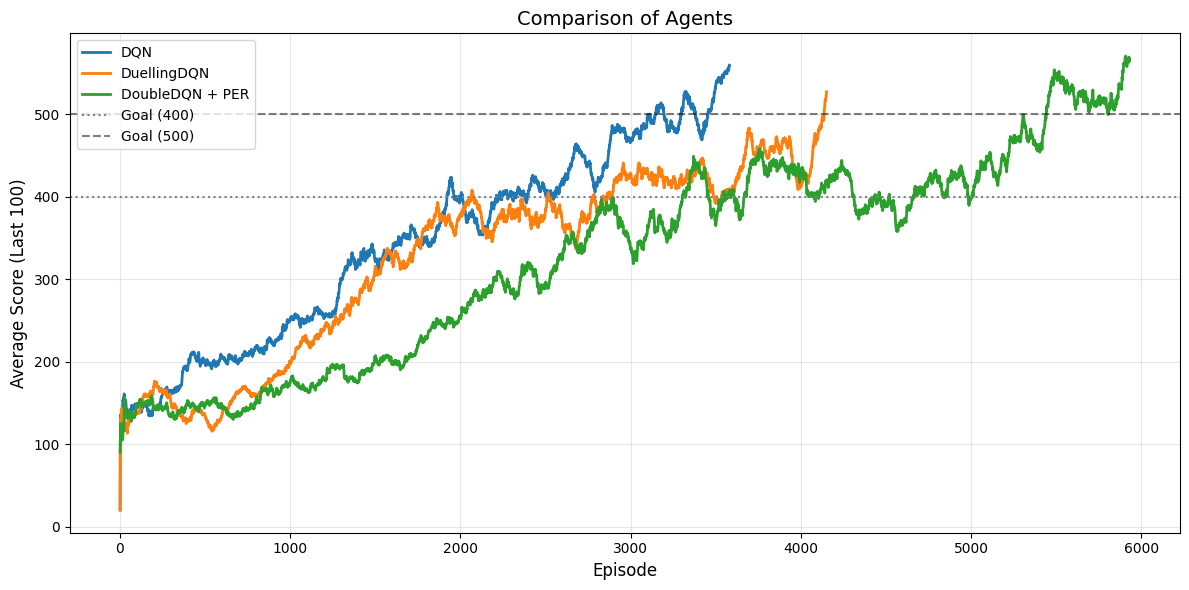

In [ ]:
files = [
    './deliverables/5_SimpleDQN_best_554.pth', 
    './deliverables/4_DuellingDQN_best_527.pth', 
    './deliverables/3_DoubleDQN_PER_best_566.pth'
]

plot_multiple_models(files)

## Agent playing

In [58]:
# Record 1 game:
# record_agent_gameplay('best_models/DoubleDQN_PER_best.pth')

# Record 3 different games:
record_agent_gameplay('deliverables/3_DoubleDQN_PER_best_566.pth', num_episodes=3)

qc Loading checkpoint: deliverables/3_DoubleDQN_PER_best_566.pth...
🎥 Recording Episode 1/3...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (160, 210) to (160, 224) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


   ✅ Saved agent_gameplay_ep1_score_370.mp4 (Score: 370.0)
🎥 Recording Episode 2/3...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (160, 210) to (160, 224) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


   ✅ Saved agent_gameplay_ep2_score_435.mp4 (Score: 435.0)
🎥 Recording Episode 3/3...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (160, 210) to (160, 224) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


   ✅ Saved agent_gameplay_ep3_score_670.mp4 (Score: 670.0)


1475.0

render if running on colab

In [ ]:
from IPython.display import HTML
from base64 import b64encode
import os

def show_video(video_path):
    """
    Displays a video within the Colab notebook.
    """
    if not os.path.exists(video_path):
        print(f"❌ Error: Video file not found at {video_path}")
        return

    mp4 = open(video_path, 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    
    return HTML(f"""
    <video width=400 controls>
          <source src="{data_url}" type="video/mp4">
          Your browser does not support the video tag.
    </video>
    """)

In [ ]:
# record_agent_gameplay('best_models/DoubleDQN_PER_best.pth', output_prefix='my_agent')
# show_video('my_agent_ep1_score_450.mp4')